# Entrenamiento de clasificador de imagenes mediante Transfer Learning

## Introduccion

Para entrenar un clasificador de imagenes desde cero que aprenda sin sobreajuste, se requiere el uso de millones de imagenes.
Por lo que es mas practico utilizar un modelo pre-entrenado con algun dominio general y ajustar los pesos al problema especifico a evaluar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader #, Dataset
from torchvision.transforms import v2 as transforms
from torchvision.models import resnet34
from torchvision.ops import sigmoid_focal_loss

# metrics
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC
from sklearn import metrics

# Progress bar
from tqdm import tqdm

# Dataset
from medmnist import ChestMNIST



In [2]:
### Parametros Iniciales

# Si tu equipo contiene una GPU con CUDA:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU disponible')
# Si tu equipo es mac con AppleSilicon:
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Acelerador MPS disponible')
# O en CPU como la plebe:
else:
    device = torch.device('cpu')
    print('CPU disponible')

GPU disponible


In [3]:
n_epochs = 15
batch_size = 48
lr = 1e-4
n_labels = 14

# modelo
Vamos a cargar nuestro modelo ResNet34, con la diferencia de que ahora no necesitamos que tenga 1000 clases, sino que la cantidad de etiquetas que tiene nuestro conjunto.
Por lo que vamos a modificar el modelo en su capa de salida

In [4]:
modelo = resnet34(weights='DEFAULT') # Cargamos el modelo preentrenado
modelo.fc = nn.Linear(512, n_labels) # Cambiamos la capa de salida para que tenga 14 neuronas
modelo = modelo.to(device) # lo cargamos a nuestra GPU

In [5]:
# optimizador
optimizador = optim.Adam(modelo.parameters(), lr=lr)

# Transformaciones


In [6]:
# Transformacion para entrenamiento
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToDtype(torch.float32, scale=True),
])

# Transformacion para test
test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

## Dataset medMNIST

El dataset medMNIST es un conjunto de datasets de prueba, estandarizados, enfocados en problemas de clasificación de imágenes biomedicas en 2D y 3D.

Dentro de sus caracteristicas, posee versiones de imagenes para ejemplos pequeños `28x28`, hasta `224x224`
Imagenes 2D y 3D 

Posee ejemplos de tejido de colon con patologías, Rayos X de pecho, Dermatoscopia, Retina, Fondo de ojo, Analisis de celulas sanguineas, imagenes de tomografía abdominal, etc.

### ChestMNIST
Este subconjunto utiliza la base de datows `ChestX-Ray14`, la que contiene alrededor de 112120 imagenes de rayos X frontales. con 30805 pacientes..
Las clases presentes en este conjunto son 
Atelectasis, Cardiomegalia, Efusión, Infiltración, Masa, Nodulo, Neumonia, Neumotorax, Consolidación, Edema, Enfisema, Fibrosis, Engrosamiento Pleural, Hernia

In [7]:
label_names = ["Atelectasis", "Cardiomegalia", "Efusión", "Infiltración", "Masa", "Nodulo", "Neumonia", "Neumotorax", "Consolidación", "Edema", "Enfisema", "Fibrosis", "Engrosamiento Pleural", "Hernia"]

In [8]:
# Conjunto Train
donwload = False
train_dataset = ChestMNIST(split='train', download=donwload, size=224, as_rgb=True, transform=train_transforms)
# Conjunto Validation
valid_dataset = ChestMNIST(split='val', download=donwload, size=224, as_rgb=True, transform=test_transforms)
# Conjunto Test
test_dataset = ChestMNIST(split='test', download=donwload, size=224, as_rgb=True, transform=test_transforms)

(-0.5, 223.5, 223.5, -0.5)

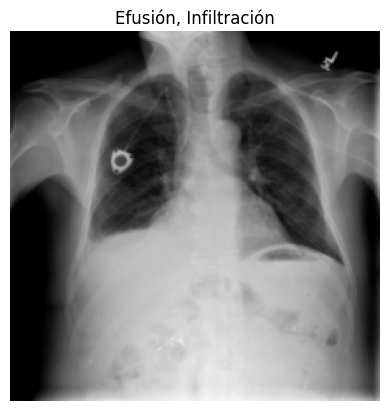

In [9]:
image, label = valid_dataset[24]
image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
present_labels = [label_names[lab] for lab in np.nonzero(label)[0]]
if present_labels:
    plt.title(', '.join(present_labels))
else:
    plt.title('No label')

#plt.title(label)
plt.axis('off')

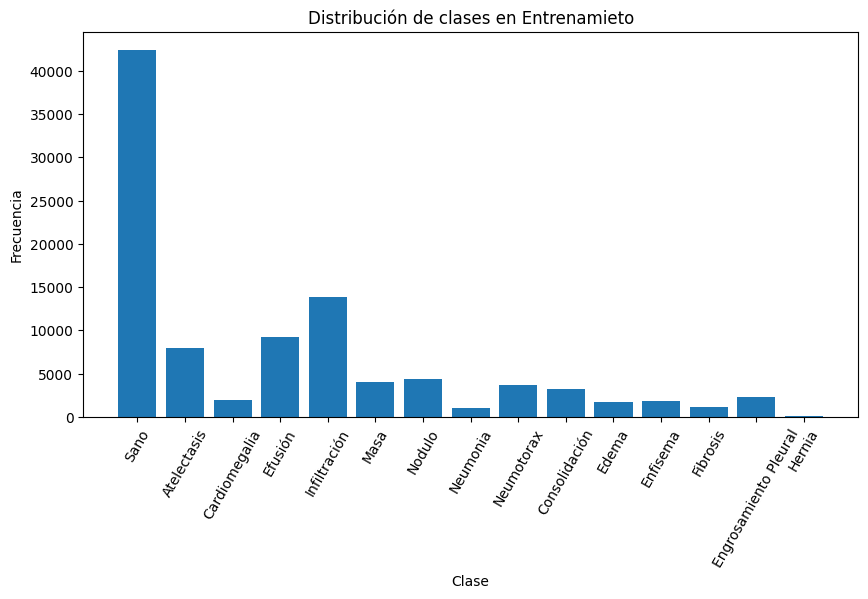

In [10]:
# Visualización de la distribución de clases en conjunto de entrenamiento

all_labels = train_dataset.labels # Matriz de etiquetas

conteos = all_labels.sum(axis=0) # Cantidad de muestras por clase
sanos = sum(all_labels.sum(axis=1) == 0) # Cantidad de muestras sanas

## Grafico
fig, ax = plt.subplots(figsize=(10, 5))
idx_clases = np.arange(len(conteos)+1)
ax.bar(idx_clases, np.append(sanos, conteos))
ax.set_title('Distribución de clases en Entrenamieto')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
ax.set_xticks(idx_clases, ['Sano'] + label_names, rotation=60, va='top', ha='center')

## Dataloader
Los Dataloaders son objetos que permiten automatizar el muestreo de nuestros datos, generando nuestros batches de entrenamiento, o mezclar los datos

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

## Metricas de entrenamiento

Una forma de evaluar si el modelo esta aprendiendo es si la función de costo disminuye.
Pero esto no indica si el modelo esta aprendiendo correctamente. Para esto se utilizan metricas que comparan que tan correcto es comparado con las etiquetas reales del conjunto

Como estamos evaluando un problema de multiples etiquetas, vamos a usas funciones de exactitud que estime la exactitud promedio dentro de todas las etiquetas.

In [12]:
acc_metric = MultilabelAccuracy(num_labels=14, average='micro').to(device)
f1_metric = MultilabelF1Score(num_labels=14, average='micro').to(device)
auc_metric = MultilabelAUROC(num_labels=14, average='micro').to(device)

## ciclo de entrenamiento 

In [13]:
for epoch in range(n_epochs):
    print(f'Epoca {epoch+1}/{n_epochs}')
    modelo.train()

    # Ciclo de entrenamiento
    pbar = tqdm(total=len(train_loader), desc='Train') # Barra de progreso
    for images, labels in train_loader:
        # Movemos las imagenes y etiquetas a la GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        optimizador.zero_grad() # Limpiamos los gradientes
        output = modelo(images) # Pasamos las imagenes por el modelo
        loss = sigmoid_focal_loss(output, labels.float(), alpha=0.3, reduction='mean') # Calculamos la perdida

        # Backward
        loss.backward()
        optimizador.step()

        # Metricas
        current_acc = acc_metric(output, labels)
        current_f1 = f1_metric(output, labels)
        current_auc = auc_metric(output, labels)

        pbar.update(1)
        pbar.set_postfix_str(f'Loss={loss.item():.4f} - Acc={current_acc.item():.2%} - F1={current_f1.item():.3f} - AUC={current_auc.item():.3f}')
    pbar.close()
    acc_metric.reset()
    f1_metric.reset()
    auc_metric.reset()

    # Ciclo de validación
    modelo.eval()
    pbar = tqdm(total=len(valid_loader), desc='Valid') # Barra de progreso
    with torch.no_grad():
        for images, labels in valid_loader:
            # Movemos las imagenes y etiquetas a la GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            output = modelo(images)

            # Metricas
            current_acc = acc_metric(output,labels)
            current_f1 = f1_metric(output, labels)
            current_auc = auc_metric(output, labels)
        
            pbar.update(1)
    pbar.close()
    valid_acc = acc_metric.compute()
    valid_f1 = f1_metric.compute()

    print(f'Metricas de Validación Epoca {epoch+1} :')
    print(f'Acc={valid_acc.item():.2%} - F1={valid_f1.item():.2%} - AUC={current_auc.item():.3f}')
    print()

    acc_metric.reset()
    f1_metric.reset()
    auc_metric.reset()

# Finalmente, guardamos el modelo
torch.save(modelo.state_dict(), 'modelo.pth')
print('Modelo guardado')       

Epoca 1/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.47it/s]


Metricas de Validación Epoca 1 :
Acc=94.96% - F1=4.14% - AUC=0.859

Epoca 2/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.78it/s]


Metricas de Validación Epoca 2 :
Acc=94.93% - F1=2.79% - AUC=0.915

Epoca 3/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.93it/s]


Metricas de Validación Epoca 3 :
Acc=94.93% - F1=1.04% - AUC=0.915

Epoca 4/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.75it/s]


Metricas de Validación Epoca 4 :
Acc=95.00% - F1=7.12% - AUC=0.891

Epoca 5/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.85it/s]


Metricas de Validación Epoca 5 :
Acc=94.97% - F1=5.00% - AUC=0.890

Epoca 6/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.63it/s]


Metricas de Validación Epoca 6 :
Acc=95.02% - F1=9.55% - AUC=0.913

Epoca 7/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.59it/s]


Metricas de Validación Epoca 7 :
Acc=94.98% - F1=7.22% - AUC=0.918

Epoca 8/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.72it/s]


Metricas de Validación Epoca 8 :
Acc=95.00% - F1=6.87% - AUC=0.909

Epoca 9/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.62it/s]


Metricas de Validación Epoca 9 :
Acc=94.99% - F1=5.59% - AUC=0.888

Epoca 10/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.66it/s]


Metricas de Validación Epoca 10 :
Acc=94.97% - F1=4.33% - AUC=0.885

Epoca 11/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.74it/s]


Metricas de Validación Epoca 11 :
Acc=95.02% - F1=9.90% - AUC=0.901

Epoca 12/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.62it/s]


Metricas de Validación Epoca 12 :
Acc=95.00% - F1=8.42% - AUC=0.904

Epoca 13/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.53it/s]


Metricas de Validación Epoca 13 :
Acc=95.01% - F1=8.82% - AUC=0.911

Epoca 14/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.78it/s]


Metricas de Validación Epoca 14 :
Acc=94.98% - F1=6.81% - AUC=0.904

Epoca 15/15


Valid: 100%|██████████| 234/234 [00:12<00:00, 18.82it/s]

Metricas de Validación Epoca 15 :
Acc=95.00% - F1=6.92% - AUC=0.898

Modelo guardado


In [14]:
# Test
all_labels = []
all_preds = []

acc_metric.reset()
f1_metric.reset()
auc_metric.reset()

with torch.no_grad():
    modelo.eval()
    pbar = tqdm(total=len(test_loader), desc='Test') # Barra de progreso
    for images, labels in test_loader:
        # Movemos las imagenes y etiquetas a la GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        output = modelo(images)
        pred = torch.sigmoid(output) 

        # Metricas
        all_labels.append(labels.cpu().numpy())
        all_preds.append(pred.detach().cpu().numpy())
        acc_metric.update(output, labels)
        f1_metric.update(output, labels)
        auc_metric.update(output, labels)

        pbar.update(1)
        
    pbar.close()
    test_acc = acc_metric.compute()
    test_f1 = f1_metric.compute()
    test_auc = auc_metric.compute()

    print(f'Metricas de Test:')
    print(f'Acc={test_acc.item():.2%} - F1={test_f1.item():.2%} - AUC={test_auc.item():.3f}')
    print()

Test: 100%|██████████| 468/468 [00:24<00:00, 19.26it/s]

Metricas de Test:
Acc=94.83% - F1=6.45% - AUC=0.872



In [15]:
# Transformamos las listas en arrays para evaluar las métricas
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(all_labels.shape, all_preds.shape)

(22433, 14) (22433, 14)


In [17]:
# Classification report
report = metrics.classification_report(all_labels, all_preds > 0.5, target_names=label_names)
print(report)

                       precision    recall  f1-score   support

          Atelectasis       0.65      0.03      0.05      2420
        Cardiomegalia       0.57      0.01      0.03       582
              Efusión       0.76      0.11      0.19      2754
         Infiltración       0.67      0.00      0.00      3938
                 Masa       0.54      0.08      0.14      1133
               Nodulo       0.48      0.01      0.01      1335
             Neumonia       0.00      0.00      0.00       242
           Neumotorax       0.57      0.01      0.03      1089
        Consolidación       0.50      0.00      0.00       957
                Edema       0.00      0.00      0.00       413
             Enfisema       0.59      0.12      0.20       509
             Fibrosis       0.00      0.00      0.00       362
Engrosamiento Pleural       0.00      0.00      0.00       734
               Hernia       1.00      0.02      0.05        42

            micro avg       0.66      0.03      0.06 

/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caribu/miniconda3/envs/tallercnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

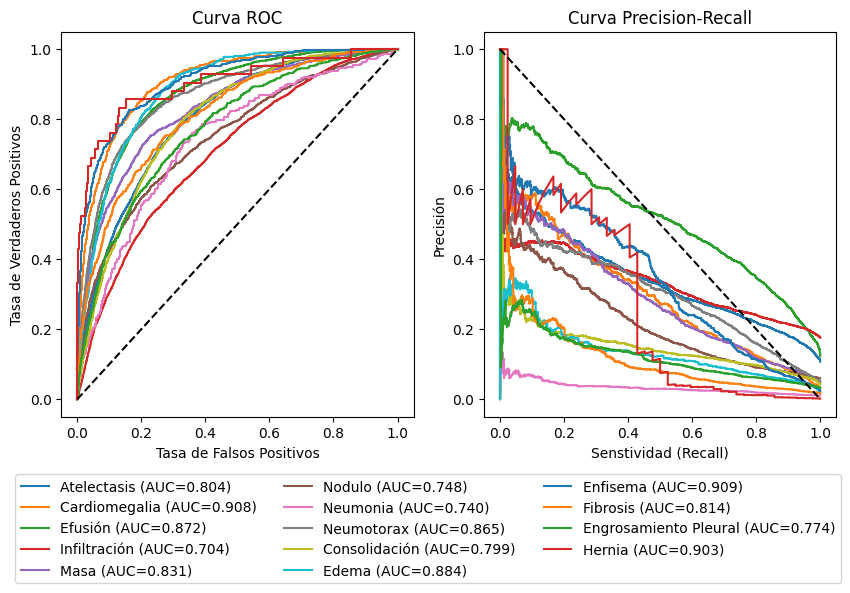

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

#Curva ROC
for i, label in enumerate(label_names):
    fpr, tpr, thresh = metrics.roc_curve(all_labels[:, i], all_preds[:, i])
    auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})')

    precision, recall, thresh = metrics.precision_recall_curve(all_labels[:, i], all_preds[:, i])
    ax[1].plot(recall, precision, label=label)

ax[0].plot([0, 1], [0, 1], 'k--')
ax[1].plot([0, 1], [1, 0], 'k--')
ax[0].set(
    xlabel='Tasa de Falsos Positivos',
    ylabel='Tasa de Verdaderos Positivos',
    title='Curva ROC'
)
ax[1].set(
    xlabel='Senstividad (Recall)',
    ylabel='Precisión',
    title='Curva Precision-Recall',
)


ax[0].legend(loc='lower left', bbox_to_anchor=(-.15, -0.45), fancybox=True, ncol=3)
#ax[1].legend()

## Referencias 

> Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

> Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.
